# A3 - Neural Machine Translation (Myanmar to English)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.optim as optim
import torchtext, datasets, math
from tqdm import tqdm # progress bar
import pickle
import random
import time
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cpu


## 1. ETL: Load Data

In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset('alt')

Generating train split:   0%|          | 0/18088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 18088
    })
    validation: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
        num_rows: 1019
    })
})

In [7]:
dataset['train']

Dataset({
    features: ['SNT.URLID', 'SNT.URLID.SNTID', 'url', 'translation'],
    num_rows: 18088
})

In [ ]:
dataset['train'][12]

In [9]:
dataset['train'][11]['translation']

{'bg': 'গতকাল ১৭৩০ ইউটিসি-তে হাউস অফ্\u200c কমন্\u200cস্\u200c-এ ইউকে-র পরিবহন সচিব রুথ কেলি এই তথ্যগুলি দিয়েছেন।',
 'en': 'Details were given by the UK Transport Secretary, Ruth Kelly, in the House of Commons at 1730 UTC yesterday.',
 'en_tok': 'Details were given by the UK Transport Secretary , Ruth Kelly , in the House of Commons at 1730 UTC yesterday .',
 'fil': 'Ang mga detalye ay ibinigay ng UK transport Secretary, na si Ruth Kelly, sa House of Commons sa ika-17:30 UTC kahapon.',
 'hi': 'कल ब्रिटेन के परिवहन सचिव रूथ केली द्वारा 1730 UTC पर हाउस ऑफ़ कॉमन्स में विवरण दिए गए।',
 'id': 'Detil diberikan oleh Sekretaris Kementerian Transportasi UK, Ruth Kelly, di Dewan Perwakilan Rakyat kemarin 17:30 UTC.',
 'ja': '詳細は昨日UTC17時30分、英国議会でイギリスのルス・ケリー運輸大臣によって伝えられた。',
 'khm': 'ព័ត៌មានលំអិតត្រូវបានផ្តល់ដោយរដ្ឋមន្ត្រីដឹកជញ្ចូន លោករ៉ូថ ខេលលី នៅក្នុងសភានៅម៉ោង1730ម្សិលមិញ។',
 'lo': 'ຂໍ້ມູນໄດ້ຖືກສະໜອງໂດຍ ເລຂາທິການຂົນສົ່ງ ສະຫະລາຊະອານາຈັກ ຣູດ ເຄລີ່ ໃນສະພາຕໍ່າ ທີ່ 1730 UTC ມື້ວານນີ້.',
 'ms': 'Butir

In [10]:
dataset['train'][11]['translation']['en']

'Details were given by the UK Transport Secretary, Ruth Kelly, in the House of Commons at 1730 UTC yesterday.'

In [11]:
dataset['train'][11]['translation']['my']

'အသေးစိတ်များ ကို မနေ့က ၁၇၃၀ ယူတီစီ ၌ အောက်လွှတ်တော် ရှိ ဗြိတိန်နိုင်ငံ ပို့ဆောင်ရေး အတွင်းရေးမှူး ရုသ်ကယ်လီ က ပေးခဲ့သည် ။'

Create a new dataset that will contain only Myanmar language as a target language and English language as a source language.

In [12]:
datasetENMY = {}

# Define source and target languages
SRC_LANGUAGE = 'en'  # Source language is English
TRG_LANGUAGE = 'my'  # Target language is Myanmar
languages   = [SRC_LANGUAGE, TRG_LANGUAGE]

for data in dataset:
# english myanmar data
    datasetENMY[data] = [{lang: row['translation'][lang] for lang in languages} for row in dataset[data]]

In [13]:
# check the size for each dataset
for data in datasetENMY:
    print(f"{data} : {len(datasetENMY[data])}")

train : 18088
validation : 1000
test : 1019


In [14]:
sample = datasetENMY['train'][100]

In [15]:
sample[SRC_LANGUAGE]

'The TimesOnline reports that the joke fell flat with Jeffrey Turner, who as Chief of Police in Clayton County, Georgia, put Mr Whitton on medical leave when he was shot in the wrist as he tried to foil a robbery earlier this summer.'

In [16]:
sample[TRG_LANGUAGE]

'ယခု နွေရာသီ အစောပိုင်း ကာလ ၌ လုယက်မှု တစ်ခု ကျူးလွန် ရန် ကြိုးစားခဲ့ သောကြောင့် လက်ကောက်၀တ် တွင် သေနတ်ကျည်မှန်ခဲ့သော မစ်စတာ ၀ှစ်တွန် ကို ကလေတွန် ကောင်တီ ၊ ဂျော်ဂျီယာပြည်နယ် မှ ၊ ရဲမှူးကြီး ဂျက်ဖရီ တာနာ မှ ဆေး ခွင့် ပေးတာနှင့် ပတ်သတ်ပြီး ၊ တိုင်းမ်စ်အွန်လိုင်း မှ ဟာသပြက်လုံးတစ်ခု ကို မှတ်တမ်းတင်ရေးသားခဲ့သည် ။'

## 2. Data Preprocessing

### 2.1 Tokenization

In [18]:
# place holders
token_transform = {}
vocab_transform = {}

##### source language <"ENG"> tokenization

In [19]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language = 'en_core_web_sm')

In [20]:
sample[SRC_LANGUAGE]
token_transform[SRC_LANGUAGE](sample[SRC_LANGUAGE])

['The',
 'TimesOnline',
 'reports',
 'that',
 'the',
 'joke',
 'fell',
 'flat',
 'with',
 'Jeffrey',
 'Turner',
 ',',
 'who',
 'as',
 'Chief',
 'of',
 'Police',
 'in',
 'Clayton',
 'County',
 ',',
 'Georgia',
 ',',
 'put',
 'Mr',
 'Whitton',
 'on',
 'medical',
 'leave',
 'when',
 'he',
 'was',
 'shot',
 'in',
 'the',
 'wrist',
 'as',
 'he',
 'tried',
 'to',
 'foil',
 'a',
 'robbery',
 'earlier',
 'this',
 'summer',
 '.']

##### Target Language <"MYR"> tokenization

In [21]:
"""

This code is updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
Ye Kyaw Thu, LST, NECTEC, Thailand updated followings:
-- added recursion limit
-- changed P_unigram and P_bigram as module level global variable
-- using binary ngram dictionary
--  set N value of this: "def __init__(self, datafile=None, unigram=True, N=102490):"
-- Last Updated: 5 Sept 2021

# References:
- Python implementation of Viterbi algorithm for word segmentation: 
- Updated version of this: https://gist.github.com/markdtw/e2a4e2ee7cef8ea6aed33bb47a97fba6
- A clean-up of this: http://norvig.com/ngrams/ch14.pdf
- For recursion limit: https://www.geeksforgeeks.org/python-handling-recursion-limit/
- A. Viterbi, "Error bounds for convolutional codes and an asymptotically optimum decoding algorithm," in IEEE Transactions on Information Theory, vol. 13, no. 2, pp. 260-269, April 1967, doi: 10.1109/TIT.1967.1054010.

"""

import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

uni_dict_bin = './app/data/unigram-word.bin'
bi_dict_bin = './app/data/bigram-word.bin'                

def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):
    ### Probability distribution estimated from unigram/bigram data
    def __init__(self, datafile=None, unigram=True, N=102490):
    #def __init__(self, datafile=None, unigram=True, N=1024908267229):
    #def __init__(self, datafile=None, unigram=True, N=8199266137832):
        #data = {}
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10 / (N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1 / N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        

P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)


def conditionalProb(word_curr, word_prev):
    ### Conditional probability of current word given the previous word.
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)


@functools.lru_cache(maxsize=2**10)
#maxlen=20
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []
    
    #print("text: ", text)
    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []
    #print("clear candidates!  candidates = []")
    for first_word, remain_word in splits:
        #pdb.set_trace()
        first_prob = math.log10(conditionalProb(first_word, prev))
        #print("first_prob of condProb(", first_word, ", ", prev, "): ", first_prob )
        remain_prob, remain_word = viterbi(remain_word, first_word)
        #print("remain_prob: ", remain_prob, ", remain_word: ", remain_word)
        candidates.append((first_prob + remain_prob, [first_word] + remain_word))
        #print("first_prob: ", str(first_prob), ", remain_prob: ", remain_prob, ", [first_word]:", [first_word], ", remain_word: ", remain_word)
        #print("Candidates: ", candidates)
        
    #print("max(candidates): " + str(max(candidates)))
    #print("====================")
    return max(candidates)

In [22]:
def my_tokenizer(text):
    if text is None:
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input = text[:]
    # text = corpus['train'][0][TRG_LANGUAGE]
    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()
    # print("listString: " + str(listString))
    wordStr = wordDelimiter.join(listString[1])
    wordClean1=wordStr.strip()
    wordClean2=wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

In [23]:
sample

{'en': 'The TimesOnline reports that the joke fell flat with Jeffrey Turner, who as Chief of Police in Clayton County, Georgia, put Mr Whitton on medical leave when he was shot in the wrist as he tried to foil a robbery earlier this summer.',
 'my': 'ယခု နွေရာသီ အစောပိုင်း ကာလ ၌ လုယက်မှု တစ်ခု ကျူးလွန် ရန် ကြိုးစားခဲ့ သောကြောင့် လက်ကောက်၀တ် တွင် သေနတ်ကျည်မှန်ခဲ့သော မစ်စတာ ၀ှစ်တွန် ကို ကလေတွန် ကောင်တီ ၊ ဂျော်ဂျီယာပြည်နယ် မှ ၊ ရဲမှူးကြီး ဂျက်ဖရီ တာနာ မှ ဆေး ခွင့် ပေးတာနှင့် ပတ်သတ်ပြီး ၊ တိုင်းမ်စ်အွန်လိုင်း မှ ဟာသပြက်လုံးတစ်ခု ကို မှတ်တမ်းတင်ရေးသားခဲ့သည် ။'}

In [24]:
token_transform[TRG_LANGUAGE] = my_tokenizer

In [25]:
token_transform[TRG_LANGUAGE](sample[TRG_LANGUAGE])

['ယခု',
 'နွေရာသီ',
 'အစောပိုင်း',
 'ကာလ',
 '၌',
 'လုယက်',
 'မှု',
 'တစ်',
 'ခု',
 'ကျူးလွန်',
 'ရန်',
 'ကြိုးစား',
 'ခဲ့',
 'သော',
 'ကြောင့်',
 'လက်',
 'ကောက်',
 '၀',
 'တ်',
 'တွင်',
 'သေနတ်ကျည်',
 'မှန်',
 'ခဲ့',
 'သော',
 'မ',
 'စ်',
 'စ',
 'တာ',
 '၀ှစ်',
 'တွန်',
 'ကို',
 'က',
 'လေ',
 'တွန်',
 'ကောင်',
 'တီ',
 '၊',
 'ဂျော်ဂျီယာ',
 'ပြည်နယ်',
 'မှ',
 '၊',
 'ရဲမှူးကြီး',
 'ဂျက်',
 'ဖရီ',
 'တာ',
 'နာ',
 'မှ',
 'ဆေး',
 'ခွင့်',
 'ပေး',
 'တာ',
 'နှင့်',
 'ပတ်',
 'သတ်',
 'ပြီး',
 '၊',
 'တိုင်းမ်စ်',
 'အွန်လိုင်း',
 'မှ',
 'ဟာသ',
 'ပြက်လုံး',
 'တစ်',
 'ခု',
 'ကို',
 'မှတ်တမ်းတင်',
 'ရေး',
 'သား',
 'ခဲ့',
 'သည်',
 '။']

In [26]:
import copy

corpus = copy.deepcopy(datasetENMY)

### 2.2 Numericalization

In [27]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

# make sure the tockens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [28]:
# helper function to yield list of tokens
# here data can be 'train' or 'val' or 'test' 
def yield_tokens(data, language):
    # language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE:1}
    
    for data_sample in data:
        yield token_transform[language](data_sample[language])
        # either first or second index

In [29]:
# stop: use vocab data instead of running the vocab_transform each loop; it takes 30 mins to run

In [30]:
# note: for the first time you may need to run this block and save the vocab.
#       next time just need to use the vocab.pkl

# from torchtext.vocab import build_vocab_from_iterator

# for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
#     # Create torchtext's Vocab object 
#     vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(corpus['train'], ln), 
#                                                     min_freq = 2,   # if not, everything will be treated as UNK
#                                                     specials = special_symbols,
#                                                     special_first = True) # indicates whether to insert symbols at the beginning or at the end                                            
# # Set UNK_IDX as the default index. This index is returned when the token is not found. 
# # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
# for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
#     vocab_transform[ln].set_default_index(UNK_IDX)

In [31]:
# # save the vocab
# import pickle
# pickle.dump(vocab_transform, open('./app/data/vocab.pkl', 'wb'))

In [32]:
# start here: load vocab 

In [33]:
# load the vocab
vocab_transform = pickle.load(open('./app/data/vocab.pkl', 'rb'))

In [34]:
vocab_transform['my']['သူ']

14

In [35]:
vocab_transform['en']['she']

153

## 3. Prepare the Data Loader

In [36]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform)    # Add BOS/EOS and create tensor

# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for row in batch:
        processed_text = text_transform[SRC_LANGUAGE](row[SRC_LANGUAGE].rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](row[TRG_LANGUAGE].rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype = torch.int64), trg_batch

In [37]:
batch_size = 64

train_loader = DataLoader(corpus['train'][:1000], batch_size = batch_size, shuffle = True , collate_fn = collate_batch)
valid_loader = DataLoader(corpus['validation'][:100]  , batch_size = batch_size, shuffle = False, collate_fn = collate_batch)
test_loader  = DataLoader(corpus['test'][:100] , batch_size = batch_size, shuffle = False, collate_fn = collate_batch)

In [38]:
for en, _, my in train_loader:
    break

In [39]:
print("English shape:", en.shape)
print("Myanmar shpae", my.shape)

English shape: torch.Size([64, 53])
Myanmar shpae torch.Size([64, 121])


## 4. Design the Model

### Encoder Layer

In [40]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        
        # Layer normalization for self-attention and feedforward layers
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        
        # Multi-head self-attention layer
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        # self.self_attention       = MultiheadAttention(hid_dim, n_heads, dropout, device, energy)
        
        # Position-wise feedforward layer
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        
        # Dropout layer for regularization
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        
        # Multi-head self-attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        # normalized
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        # Position-wise feedforward
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [41]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attention, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src

### Multi-Head Attention

#### General Attention

In [42]:
class MultiHeadGeneralAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        # src, src, src, src_mask
        # query = [batch size, query len, hid dim]
        # key   = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch_size, n heads, query len, head_dim]
        
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale 
        # Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        # energy = [batch_size, n heads, query len, key len]
        
        # for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        # attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        # [batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        # x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        # x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query len, hid dim]
        
        return x, attention

#### Additive Attention

In [43]:
class MultiHeadAdditiveAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        # input >> Q, K, V
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        # for additive v, U, W
        self.vv = nn.Linear(self.head_dim, 1, bias = False)
        self.W = nn.Linear(self.head_dim, self.head_dim) # for decoder input_ (W2)
        self.U = nn.Linear(self.head_dim, self.head_dim)  # for encoder_outputs (W1)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask = None):
        
        # src, src, src, src_mask
        # query = [batch size, query len, hid dim]
        # key   = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        query_len  = query.shape[1]
        key_len    = key.shape[1]
        
        # linear transform for the input
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q=K=V: [batch_size, src len, hid_dim]
        
        # update the size for matrix multiplication
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch_size, n heads, query len, head_dim]
    
        Q = Q.view(batch_size, self.n_heads, query_len, 1, self.head_dim)
        K = K.view(batch_size, self.n_heads, 1, key_len, self.head_dim)
        
        # calculate the energy : for additive
        energy = (self.vv(torch.tanh(self.W(Q) + self.U(K))) / self.scale).squeeze(4)
        # Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        # energy = [batch_size, n heads, query len, key len, 1] >> squeeze(4)
        # energy = [batch_size, n heads, query len, key len]
        
        # for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        # attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        # [batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        # x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        # x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query len, hid dim]
        
        return x, attention
    

#### Multiplicative Attention

In [44]:
class MultiHeadMultiplicativeAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.W        = nn.Linear(self.head_dim, self.head_dim) # for decoder input_ (note: not the same)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask = None):
        # src, src, src, src_mask
        # query = [batch size, query len, hid dim]
        # key   = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q=K=V: [batch_size, src len, hid_dim]
        
        # update the size for matrix multiplication
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch_size, n heads, query len, head_dim]
        
        # calculate the energy : to fix for multiplicative
        energy = torch.matmul(self.W(Q), K.permute(0,1,3,2)) / self.scale # multiplicative attention
        # Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        # energy = [batch_size, n heads, query len, key len]
        
        # for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        # attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        # [batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        # x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        # x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        # x = [batch_size, query len, hid dim]
        
        return x, attention

#### Position-wise Feed Forward Layer

In [45]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x: [batch size, src len, hid dim]
        
        # Apply the first linear transformation followed by ReLU activation and dropout
        x = self.dropout(torch.relu(self.fc1(x)))
        # x: [batch size, src len, pf_dim]
        
        # Apply the second linear transformation
        x = self.fc2(x)
        # x: [batch size, src len, hid dim]
        
        return x

### Decoder Layer

In [46]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attention):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = attention(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = attention(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        # print("After self-attention:")
        # print("trg shape:", trg.shape)
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        # print("After encoder attention:")
        # print("trg shape:", trg.shape)
        # print("attention shape:", attention.shape)
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        # print("After feedforward:")
        # print("trg shape:", trg.shape)
        
        return trg, attention

### Decoder

In [47]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, attention, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attention)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        # print("After embedding:")
        # print("trg shape:", trg.shape)
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        # print("After decoder layers:")
        # print("trg shape:", trg.shape)
        # print("attention shape:", attention.shape)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        # print("After fc_out:")
        # print("output shape:", output.shape)
        
        return output, attention

### Seq2Seq

In [48]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.encoder     = encoder
        self.decoder     = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device      = device
        
    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 5. Training

In [49]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

### preparation

In [50]:
# initialize parameters
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim     = 256
enc_layers  = 3
dec_layers  = 3
enc_heads   = 8
dec_heads   = 8
enc_pf_dim  = 512
dec_pf_dim  = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

# Initialize Encoder and Decoder with different attention mechanisms
enc_general_attention = Encoder(input_dim, 
                        hid_dim, 
                        enc_layers, 
                        enc_heads, 
                        enc_pf_dim, 
                        enc_dropout, 
                        device,
                        attention = MultiHeadGeneralAttentionLayer
                        # energy = general
                        )
dec_general_attention = Decoder(output_dim, 
                                hid_dim, 
                                dec_layers, 
                                dec_heads, 
                                dec_pf_dim, 
                                enc_dropout, 
                                device,
                                attention = MultiHeadGeneralAttentionLayer)

enc_multiplicative_attention = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, device, attention = MultiHeadMultiplicativeAttentionLayer)
dec_multiplicative_attention = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, dec_dropout, device, attention = MultiHeadMultiplicativeAttentionLayer)

enc_additive_attention       = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, device, attention = MultiHeadAdditiveAttentionLayer)
dec_additive_attention       = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, dec_dropout, device, attention = MultiHeadAdditiveAttentionLayer)

# Create models with different attentions
# Optionally, apply weight initialization
model_general_attention      = Seq2SeqTransformer(enc_general_attention, dec_general_attention, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_general_attention.apply(initialize_weights)

model_additive_attention     = Seq2SeqTransformer(enc_additive_attention, dec_additive_attention, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_additive_attention.apply(initialize_weights)

model_multiplicative_attention = Seq2SeqTransformer(enc_multiplicative_attention, dec_multiplicative_attention, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative_attention.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16912, 256)
    (pos_embedding): Embedding(1000, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadMultiplicativeAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (W): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_feature

In [51]:
all_models = {
    'generalAttention': model_general_attention,
    'additiveAttention' : model_additive_attention,
    'multiplicativeAttention': model_multiplicative_attention
    }

In [52]:
# we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    # for item in params:
    #     print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
# count_parameters(model)
for i,key in enumerate(all_models):
    count_parameters(all_models[key])

______
12914013
______
12933309
______
12923517


In [53]:
lr = 0.0005

optimizer_general_attention = optim.Adam(model_general_attention.parameters(), lr=lr)
criterion_general_attention = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

optimizer_multiplicative_attention = optim.Adam(model_multiplicative_attention.parameters(), lr=lr)
criterion_multiplicative_attention = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

optimizer_additive_attention = optim.Adam(model_additive_attention.parameters(), lr=lr)
criterion_additive_attention = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

### training

In [54]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [55]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [56]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [57]:
# time calculation function
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
# for model training

# to store the model training records for each model
training_records = {}

def train_model(model, optimizer, criterion, model_name):
    
    best_valid_loss = float('inf')
    best_train_loss = float('inf')
    best_valid_PPL  = float('inf')
    best_train_PPL  = float('inf')
    
    num_epochs = 10
    clip       = 1

    save_path = f'app/models/{model_name}.pt'

    train_losses = []
    valid_losses = []
    
    start = time.time()

    for epoch in range(num_epochs):
        
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_valid_PPL = math.exp(valid_loss)
            best_train_loss = train_loss
            best_train_PPL  = math.exp(train_loss)
            torch.save(model.state_dict(), save_path)
        
        # print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    end = time.time()
    total_mins, total_secs = epoch_time(start, end)
    
    # save the records
    training_records[model_name] = {'train_losses'   : train_losses,
                               'valid_losses'   : valid_losses,
                               'best_train_loss': best_train_loss,
                               'best_train_PPL' : best_train_PPL,
                               'best_valid_loss': best_valid_loss,
                               'best_valid_PPL' : best_valid_PPL,
                               'total_mins'     : total_mins,
                               'total_secs'     : total_secs}
    
    print(f"Time: {total_mins}m ,{total_secs}s")
    print(f'\tLast epoch Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tLast epoch Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### train model

In [59]:
# train_model(model, optimizer, criterion)

# general attention
train_model (model_general_attention, optimizer_general_attention, criterion_general_attention, "generalAttention")

Time: 18m ,20s
	Last epoch Train Loss: 3.953 | Train PPL:  52.066
	Last epoch Val. Loss: 5.248 |  Val. PPL: 190.248


In [60]:
# additive attention
train_model (model_additive_attention, optimizer_additive_attention, criterion_additive_attention, "additiveAttention")

Time: 88m ,25s
	Last epoch Train Loss: 3.939 | Train PPL:  51.362
	Last epoch Val. Loss: 5.244 |  Val. PPL: 189.355


In [61]:
# multiplicative attention
train_model (model_multiplicative_attention, optimizer_multiplicative_attention, criterion_additive_attention, "multiplicativeAttention")

Time: 17m ,1s
	Last epoch Train Loss: 3.974 | Train PPL:  53.211
	Last epoch Val. Loss: 5.302 |  Val. PPL: 200.830


### plotting

In [62]:
# plotting fn
def fn_plot(train_losses, valid_losses,model):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses, label = 'train loss')
    ax.plot(valid_losses, label = 'valid loss')
    plt.legend()
    plt.title(model)
    ax.set_xlabel('updates')
    ax.set_ylabel('loss')

In [63]:
training_records

{'generalAttention': {'train_losses': [7.952621251344681,
   6.503568708896637,
   6.030757516622543,
   5.679919868707657,
   5.304770141839981,
   4.950529932975769,
   4.654195636510849,
   4.397458910942078,
   4.165863215923309,
   3.9525091648101807],
  'valid_losses': [6.97575044631958,
   6.2458038330078125,
   5.976718425750732,
   5.753986597061157,
   5.5416529178619385,
   5.405506372451782,
   5.320444345474243,
   5.287436008453369,
   5.257790565490723,
   5.248330116271973],
  'best_train_loss': 3.9525091648101807,
  'best_train_PPL': 52.065844856671205,
  'best_valid_loss': 5.248330116271973,
  'best_valid_PPL': 190.24831049811806,
  'total_mins': 18,
  'total_secs': 20},
 'additiveAttention': {'train_losses': [7.983359634876251,
   6.527632623910904,
   6.030588090419769,
   5.648031920194626,
   5.2622769474983215,
   4.901324272155762,
   4.605447620153427,
   4.357057809829712,
   4.13521346449852,
   3.9388954788446426],
  'valid_losses': [6.995584964752197,
   6.

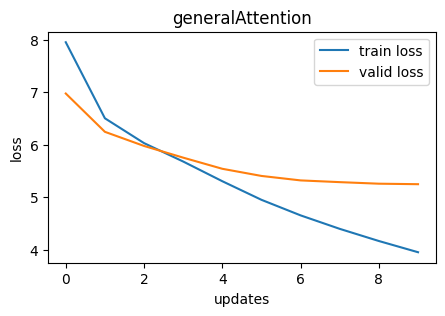

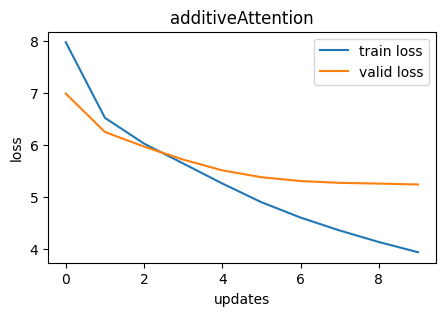

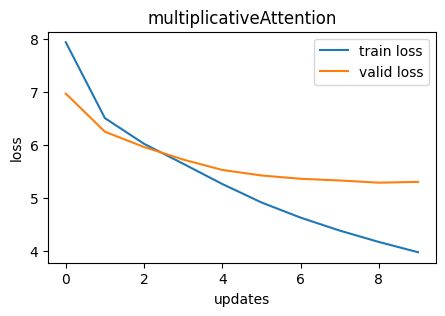

In [64]:
for i, key in enumerate(all_models):
    fn_plot(training_records[key]['train_losses'], training_records[key]['valid_losses'],key)

## 6. Testing

In [65]:
# myanmar dataset have 1 null row, correct in collate function
def test(model, model_name, criterion):
    
    save_path = f'app/models/{model_name}.pt'
    model.load_state_dict(torch.load(save_path))
    test_loss = evaluate(model, test_loader, criterion, test_loader_length)
    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

In [66]:
# test generalAttention
test(model_general_attention, 'generalAttention', criterion_general_attention)

| Test Loss: 5.186 | Test PPL: 178.719 |


In [67]:
# test additiveAttention
test(model_additive_attention, 'additiveAttention', criterion_additive_attention)

| Test Loss: 5.180 | Test PPL: 177.678 |


In [68]:
# test multiplicativeAttention
test(model_multiplicative_attention, 'multiplicativeAttention', criterion_multiplicative_attention)

| Test Loss: 5.212 | Test PPL: 183.435 |


## 7. Inference

In [69]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [70]:
def greedy_decode(model, src, max_len, device):
    # print(src)
    src = text_transform[SRC_LANGUAGE](src).to(device).unsqueeze(0)
    # print(src.shape)
    model.eval()
    
    # src = src.unsqueeze(0).to(device)
    src_mask    = model.make_src_mask(src)
    memory      = model.encoder(src, src_mask)
    trg_indexes = [SOS_IDX]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        # print(trg_tensor.shape)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, _ = model.decoder(trg_tensor, memory, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == EOS_IDX:
            break
    
    # print(trg_indexes)
    trg_tokens = [mapping[i] for i in trg_indexes]
    return trg_tokens[1:]  # Exclude the <sos> token

In [71]:
# Example usage
src_sentence = "limited"

output_sentence = greedy_decode(model_general_attention, src_sentence, max_len=5, device=device)
print("Predicted Sentence:", ' '.join(output_sentence))

Predicted Sentence: " ကျွန်တော် တို့ က တည်း


In [72]:
output_sentence = greedy_decode(model_additive_attention, src_sentence, max_len=5, device=device)
print("Predicted Sentence:", ' '.join(output_sentence))

Predicted Sentence: " ကျွန်တော် တို့ က နေ


In [73]:
output_sentence = greedy_decode(model_multiplicative_attention, src_sentence, max_len=5, device=device)
print("Predicted Sentence:", ' '.join(output_sentence))

Predicted Sentence: " ဒီ နေ ရာ မှာ


## 8. Attention

In [75]:
src_text = corpus['train'][0]['en']
print(src_text)

trg_text = corpus['train'][0]['my']
print(trg_text)

Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.
ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။


In [76]:
src = text_transform[SRC_LANGUAGE](src_text).to(device).unsqueeze(0)
trg = text_transform[TRG_LANGUAGE](trg_text).to(device).unsqueeze(0)

In [77]:
src

tensor([[    2,  1434,    25,  1217,  2841,  1524,    17,   459,    10,  7497,
          2960,     7,     4,   291,  2601,   221,   547,    26,     0,  9151,
         14061,     5,  2482,     5,   376,     6,     3]])

In [78]:
trg

tensor([[   2,  418,   50,   24,  189,  125, 3082, 2134, 3193,  454,   96,  845,
           20,   33,  150,  286, 1305,   15,  995,    4, 2446,    6,  129,  161,
           58,  225,  415,   60, 3559,  103,   15, 1175,   89,   24,    4,    8,
            3]])

In [79]:
text_length = torch.tensor([src.size(0)]).to(dtype=torch.int64)
text_length

tensor([1])

In [80]:
# def load_attention_model(model, src_text, trg_text, model_name):
#     # load the model saveing path
#     save_path = f'./app/models/{model_name}.pt'
#     model.load_state_dict(torch.load(save_path))
#     model.eval()
#     with torch.no_grad():
#         output, attentions = model(src_text, trg_text) #turn off teacher forcing
        
#     return output, attentions

# general_output, general_attentions   = load_attention_model(model_additive_attention,src, trg, 'generalAttention')
# multi_output, multi_attentions       = load_attention_model(model_multiplicative_attention, src, trg, 'multiplicativeAttention')
# additive_output, additive_attentions = load_attention_model(model_additive_attention, src, trg, 'additiveAttention')

In [81]:
with torch.no_grad():
    general_output, general_attentions = model_general_attention(src, trg)
with torch.no_grad():
    multiplicative_output, multiplicative_attentions = model_multiplicative_attention(src, trg)
with torch.no_grad():
    additive_output, additive_attentions = model_additive_attention(src, trg)

In [82]:
def get_output(output):
    output = output.squeeze(0)
    output = output[1:]
    output_max = output.argmax(1)
    trg_tokens = ['<sos>'] + [mapping[TRG_LANGUAGE][token.item()] for token in output_max]
    return trg_tokens

In [83]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](src_text) + ['<eos>']

In [84]:
# trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
# trg_tokens

In [85]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention[0, 0, :, :]
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [86]:
trg_tokens = get_output(general_output)
display_attention(src_tokens, trg_tokens, general_attentions)
print(trg_tokens)

TypeError: list indices must be integers or slices, not str

In [ ]:
trg_tokens = get_output(multiplicative_output)
display_attention(src_tokens, trg_tokens, multiplicative_attentions)

In [ ]:
trg_tokens = get_output(additive_output)
display_attention(src_tokens, trg_tokens, additive_attentions)

# Task 3: Model Evaluation and Verification

### 1. Performance

#### according to translation accuracy

To compare the performance of these attention mechanisms in terms of translation accuracy: I may say '0'. May be because of my train/test/validation dataset limitation or the tokenization of Myanmar Language is not very strong enough.

Underneat, I do some testing using BLEU for three attention mechanisms by generating one random sentence from my dataset. The result of bleu remains zero.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

src_text = corpus['train'][100]['en']
print(f"Source Sentence: {src_text}")
trg_text = corpus['train'][100]['my']
print(f"Target Sentence: {trg_text}")

# get random sample input and target
src_token = token_transform[SRC_LANGUAGE](src_text)
trg_token = token_transform[TRG_LANGUAGE](trg_text)

# get model predicted output
model_output = greedy_decode(model_general_attention, src_sentence, max_len=10, device=device)
print("Predicted Sentence:", ' '.join(output_sentence))

# compare with bleu
bleu_score = sentence_bleu([trg_token], model_output)
print(f'BLEU Score: {bleu_score * 100:.2f}%')

In [ ]:
model_output_addi = greedy_decode(model_additive_attention, src_sentence, max_len=10, device=device)
print("Predicted Sentence:", ' '.join(output_sentence))

bleu_score = sentence_bleu([trg_token], model_output_addi)
print(f'BLEU Score: {bleu_score * 100:.2f}%')

In [ ]:
model_output_multi = greedy_decode(model_multiplicative_attention, src_sentence, max_len=10, device=device)
print("Predicted Sentence:", ' '.join(output_sentence))

bleu_score = sentence_bleu([trg_token], model_output_addi)
print(f'BLEU Score: {bleu_score * 100:.2f}%')

#### according to the computational efficiency

For the training, I used batch size = 64.
The dataset contains pair of English and Myanmar according to the followings size:
<ul>
    <li> training set  : 1000 lines </li>
    <li> validation set:  100 lines </li>
    <li> testing set   :  100 lines </li>
</ul>

Then I train the model using three different attentions. Here are the comparison according to the computational efficiency:
<table>
    <tr>
        <th>  </th>
        <td> General Attention </td>
        <td> Additive Attention </td>
        <td> Multiplicative Attention </td>
    </tr>
    <tr>
        <th> Training Time </th>
        <td> 18m : 20s </td>
        <td> 88m : 25s </td>
        <td> 17m : 1s </td>
    </tr>
</table>

According to the computational efficiency, Multiplicative Attention is the best.

In [88]:
for i, key in enumerate(all_models):
    print(f"Training Time for {key} ==> {training_records[key]['total_mins']}m : {training_records[key]['total_secs']}s")

Training Time for generalAttention ==> 18m : 20s
Training Time for additiveAttention ==> 88m : 25s
Training Time for multiplicativeAttention ==> 17m : 1s
